In [1]:
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
import pingouin as pg
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#data = pd.read_csv("U:\\Research\\ADRC_Jupyter\\1FloridaAlzheimersDi_DATA_2020-07-01_1438.csv")
data = pd.read_csv("1FloridaAlzheimersDi_DATA_2020-07-17_1448.csv", dtype = {'ptid':str})
#data = pd.read_csv("1FloridaAlzheimersDi_DATA_2020-07-01_1438.csv")
#data = pd.read_csv("redcap_test2.csv")
data.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (22,24,26,30,137,214,241,271,287,429,506,533,563,579,591,600,605,609,611,668,669,774,782,783,820,853,858,863,868,873,878,883,888,941,969,987,989,991,995,1002,1003,1010,1013,1020,1030,1032,1034,1036,1038,1040,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1125,1134,1148,1158,1186,1369,1371,1391,1402,1424,1537,1570,1659,1732,1754,1756,1758,1760,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2519,2520,2521,2522,2523,2524,2548,2550,2553,2577,2578,2581,2623,2627,2628) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ptid,redcap_event_name,redcap_data_access_group,formver,adcid,visitmo,visitday,visityr,visitnum,initials,...,conc_1,conc_2,ave_conc,percent_cv_conc,notes,neurofilament_light_complete,abeta40_plasma_ipms,abeta42_plasma_ipms,abeta4240_plasma_ipms,c2n_complete
0,110001,initial_visit_year_arm_1,msmc_clinic,3.0,41.0,9.0,1.0,2015.0,1.0,MTG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,110001,milestone_1_arm_1,msmc_clinic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,110001,neuropathology_arm_1,msmc_clinic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,110001,genetics_arm_1,msmc_clinic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,110001,metadata_arm_1,msmc_clinic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Apply LRN Diagnostic Criteria
* Use the Algorithm Diagnosis
* If dementia is diagnosed and alzdis = 1 --> Diagnosis is AD
* If dementia is diagnosed and alzdis != 1 --> set as "Other dementia"
#### lrnDiag key
* AD = Alzheimer's
* pMCIc = Pre-MCI Clinical (CDR > 0)
* pMCIn = Pre-MCI Neuro-psychological (CDR = 0)
* eMCI = early MCI?
* lMCI = late MCI
* OD = Other Dementia
* CN = Cognitively normal

In [3]:
# Apply Diagnostic Criteria, Based largely on the Automated Calculator
data["lrnDiag"] = ""
data.loc[(data['consesusfinaldx'] == 5) & (data['alzdis'] == 1) & (data['alzdisif'] == 1), 'lrnDiag'] = "4AD"
data.loc[data['consesusfinaldx'] == 61, 'lrnDiag'] = "5pMCIc"
data.loc[data['consesusfinaldx'] == 62, 'lrnDiag'] = "6pMCIn"
data.loc[(data['consesusfinaldx'] == 2), 'lrnDiag'] = "2EMCI"
data.loc[(data['consesusfinaldx'] == 22), 'lrnDiag'] = "3LMCI"
data.loc[(data['consesusfinaldx'] == 0), 'lrnDiag'] = "1CN"
data.loc[(data['consesusfinaldx'] == 5) & (pd.isnull(data['alzdis'])), 'lrnDiag'] = "7OD"
#data.loc[(data['consesusfinaldx'] != 5) & (data['normcog'] == 1), 'lrnDiag'] = "CogNorm"

### Clean up clinical dataset
##### Notes:
* Need to confirm that edu and educ are on the same scale, they are (rarely) different values
* MMSE data is pulled from fl9_mmse_c_total and fl9_mmse_c_total
    * but there are at least 2 other sources: 'c1s_1d_mmse' and 'fu_mmse', 'ndv_naccmmse'

In [4]:
# Clean up clinical data in which demographic information is in multiple places
data.loc[(pd.isnull(data['educ'])) & (pd.notna(data['edu'])), 'educ'] = data.loc[(pd.isnull(data['educ'])) & (pd.notna(data['edu'])), 'edu']

#Combine MMSE data from two sources
data['lrnMMSE'] = data.fl9_mmse_c_total
data.loc[(pd.isnull(data.lrnMMSE)) & (pd.notna(data.fl9s_mmse_c_total)), 'lrnMMSE'] = data.loc[(pd.isnull(data.lrnMMSE)) & (pd.notna(data.fl9s_mmse_c_total)), 'fl9s_mmse_c_total']

# remove data that indicates an error in collection
data.loc[data.fl9_lassi_delayed_raw == 999] = None
data.loc[data.mocatots == 88] = None
data.loc[data.fu_mocatots == 88] = None
data.loc[data.apoe == 9] = None

In [5]:
def copy_from_fu(f1):
    # if data is missing from IVP, copy from FVP
    global data
    data.loc[(pd.isnull(data[f1])) & (pd.notna(data['fu_'+f1])), f1] = data.loc[(pd.isnull(data[f1])) & (pd.notna(data['fu_'+f1])), 'fu_'+f1]
    return

copy_from_fu('birthyr')
copy_from_fu('mocatots')
copy_from_fu('sex')
copy_from_fu('amylpet')
copy_from_fu('amylcsf')
copy_from_fu('csftau')
copy_from_fu('taupetad')
copy_from_fu('fdgad')
copy_from_fu('cdrsum')

In [6]:
# Calculate visit date
data["visitDate"] = pd.to_datetime((data.visityr*10000+data.visitmo*100+data.visitday).apply(str),format='%Y%m%d')

In [7]:
# Rename some variables to make more intuitive
data["NFL"] = data["ave_conc"]
data = data.drop("ave_conc", axis=1)

### Get imaging data


In [8]:
# Load the imaging data
data_fw = pd.read_csv("Compile_20200709\\Diffusion_data.csv")
#data_fw = pd.read_csv("Compile_20200702\\img_test.csv")

In [9]:
# Get imaging date from Subject ID
data_fw["ptid"] = data_fw.Subject.str.split('_', expand = True)[0]
data_fw["month"] = data_fw.Subject.str.split('_', expand = True)[1].str[:2].astype(int)
data_fw["day"] = data_fw.Subject.str.split('_', expand = True)[1].str[2:4].astype(int)
data_fw["year"] = data_fw.Subject.str.split('_', expand = True)[1].str[4:].astype(int)
data_fw["imgDate"] = pd.to_datetime((data_fw.year*10000+data_fw.month*100+data_fw.day).apply(str),format='%Y%m%d')

In [10]:
# Convert MR IDs to ptid
data_fw.loc[data_fw.ptid == 'MR5061','ptid'] = '110276'
data_fw.loc[data_fw.ptid == 'MR5062','ptid'] = '110269'
data_fw.loc[data_fw.ptid == 'MR5063','ptid'] = '110323'
data_fw.loc[data_fw.ptid == 'MR5066','ptid'] = '110365'
data_fw.loc[data_fw.ptid == 'MR5067','ptid'] = '110359'
data_fw.loc[data_fw.ptid == 'MR5068','ptid'] = '110349'
data_fw.loc[data_fw.ptid == 'MR5069','ptid'] = '110367'

#### Subjects with more than one diffusion scan

In [11]:
data_fw[data_fw.duplicated(['ptid'])]

,Subject,aSN_FW,pSN_FW,LC2TECL_flip_s-2_FW,LC2TECL_FW,Ch1-2_L_FW,Ch1-2_R_FW,Ch3_L_FW,Ch3_R_FW,Ch4_L_FW,...,Ch4_R_MD,Ch4p_L_MD,Ch4p_R_MD,Hipp_L_MD,Hipp_R_MD,ptid,month,day,year,imgDate


In [12]:
#Full join clinical and imaging data
data_fw = data_fw.set_index('ptid')
data_all = data.join(data_fw, on='ptid')

#Reindex for a fresh set of identifiers for all combinations of data related to a ptid
#    Do not change the index after this without also adjusting get_valid_bool
data_all = data_all.reset_index()
data_clean = pd.DataFrame()

### Add clinical data to the imaging data table

In [13]:
def find_n_add_field(colName):
    # Function gets a boolean column that designates which rows to use for that metric
    
    # Combine the ROI and clinical tables, matching by ptid, keep all clinical table rows
    # If there are duplicate ptid entries on either table it will create all combinations (Full Join)
    data3 = data.join(data_fw, on='ptid')
    # index should match data_all at this point
    data3 = data3.reset_index()
    # Fill null values with the oldest date possible so that real visit dates
    #    are prioritized but missing visit dates are not completely ignored
    data3.visitDate = data3.visitDate.fillna(pd.to_datetime('17760704'))

    # Calculate the time difference between the imaging date and the visit date
    #    Only use the rows in which a diagnosis, imaging date, and visit date are given
    data3["visitDateDiff"] = data3.apply(lambda x: abs(x.imgDate - x.visitDate) if x[colName]!="" and pd.notna(x[colName]) and pd.notna(x.imgDate) and pd.notna(x.visitDate) else pd.Timedelta('NaT'), axis = 1)

    # grouped by subject, get the visit that is closes to the imaging date and has a diagnosis
    #    Join these results with the existing combined table
    data4 = data3.join(data3.groupby(['ptid','imgDate'])['visitDateDiff'].agg(['min']).rename(columns={'min':'minDateDiff'}), on=['ptid','imgDate'])

    # Create a single column boolean tag for the single visit for each scan that has the most relevant diagnosis information
    data4[colName+'Valid'] = data4.apply(lambda x: 1 if x.visitDateDiff == x.minDateDiff else 0, axis=1)

    #output the single bool column with name that is the input colname+Valid
    #return data4[colName+'Valid']
    
    # Add bool column to full join
    global data_all
    data_all = data_all.join(data4[colName+'Valid'])
    
    # Add data to clean dataset
    global data_clean
    if data_clean.empty:
        data_clean = data_fw.join(data_all.loc[data_all[colName+'Valid'] == 1, ['ptid','imgDate',colName]].set_index(['ptid','imgDate']), on=['ptid','imgDate'])
    else:
        data_clean = data_clean.join(data_all.loc[data_all[colName+'Valid'] == 1, ['ptid','imgDate',colName]].set_index(['ptid','imgDate']), on=['ptid','imgDate'])

    return

#### To Do: Collect the time difference for each variable too

In [14]:
find_n_add_field('lrnDiag')
find_n_add_field('birthyr')
find_n_add_field('sex')
find_n_add_field('educ') #years of education
find_n_add_field('apoe') #APoE status
find_n_add_field('mocatots') #MOCA
find_n_add_field('amylcsf')
find_n_add_field('csftau')
find_n_add_field('cdrsum') #CDR-SB
find_n_add_field('lrnMMSE') #MMSE

In [15]:
find_n_add_field('NFL') # NFL
find_n_add_field('abeta40_plasma_ipms') #A-beta marker in blood plasma samples
find_n_add_field('abeta42_plasma_ipms')
find_n_add_field('abeta4240_plasma_ipms') #Ratio of 40 and 42
find_n_add_field('fl9_lassi_delayed_raw') #LASSI (delayed) score
find_n_add_field('fl9_lassi_delayed_no') #Inclusion errors in LASSI delayed

In [16]:
#Calculate age from birth yr and imag date
data_clean['imgAge'] = pd.DatetimeIndex(data_clean.imgDate).year - data_clean.birthyr

In [17]:
#find_n_add_field('c1s_1d_mmse')
#find_n_add_field('fu_mmse')
#find_n_add_field('fl9_mmse_c_total')
#find_n_add_field('fl9s_mmse_c_total')
#find_n_add_field('ndv_naccmmse')

In [18]:
data.loc[pd.notnull(data.abeta40_plasma_ipms)]

,ptid,redcap_event_name,redcap_data_access_group,formver,adcid,visitmo,visitday,visityr,visitnum,initials,...,notes,neurofilament_light_complete,abeta40_plasma_ipms,abeta42_plasma_ipms,abeta4240_plasma_ipms,c2n_complete,lrnDiag,lrnMMSE,visitDate,NFL


In [19]:
# Check the combined dataset
#data_all.loc[data_all.ptid == '110032', ['ptid','visitDate','imgDate','fu_birthyr','lrnDiag','fu_mocatots','sex','apoe','educ','lrnDiagValid','sexValid','apoeValid','birthyrValid','mocatotsValid']]
#data_all.loc[data_all.ptid == '110083', ['ptid','lrnDiag','ndv_mocatots','mocatots','fu_mocatots']]
#data_all.loc[data_all.ptid == '110083', ['ptid','lrnDiag','consesusfinaldx','alzdis','fu_mocatots']]
#data_all.loc[data_all.ptid == '110245', ['ptid','lrnDiag','consesusfinaldx','alzdis','normcog','demented','mciamem','mcinon1','impnomci']]
data_all.loc[data_all.consesusfinaldx == 9, ['ptid','lrnDiag','consesusfinaldx','alzdis','normcog','demented','mciamem','mcinon1','impnomci']]

,ptid,lrnDiag,consesusfinaldx,alzdis,normcog,demented,mciamem,mcinon1,impnomci
176,110022,,9.0,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Checked the cleaned dataset
#data_clean.loc[pd.isnull(data_clean.lrnDiag),['lrnDiag']]
data_clean.loc[data_clean.amylcsf != 8,['lrnDiag', 'amylcsf']]

,lrnDiag,amylcsf
ptid,,
110188,3LMCI,0.0
110245,NaN,NaN
110328,1CN,1.0
110383,2EMCI,NaN
110401,NaN,NaN


In [21]:
#data_clean.groupby('lrnDiag')['fl9_lassi_delayed_raw'].agg(['min','max','count','nunique', 'mean'])
data_clean.groupby('apoe')['Subject'].agg(['count','nunique'])

,count,nunique
apoe,,
1.0,94,94
2.0,49,49
3.0,17,17
4.0,11,11
6.0,3,3


In [22]:
data_clean.groupby('lrnDiag')['Subject'].agg(['count','nunique'])

,count,nunique
lrnDiag,,
1CN,31,31
2EMCI,77,77
3LMCI,24,24
4AD,23,23
5pMCIc,15,15
6pMCIn,18,18
7OD,8,8


In [23]:
#Output cleaned dataset to a csv
data_clean.to_csv('Output_clean.csv')

In [24]:
# Create a cleaned dataset without pre-mci and OD
data_clean2 = data_clean.copy()
data_clean2.loc[(data_clean.lrnDiag == '7OD') | (data_clean.lrnDiag == '5pMCIc') | (data_clean.lrnDiag == '6pMCIn'),'lrnDiag'] = None

In [25]:
data_clean2.to_csv('Output_clean2.csv')

### Stats Time!

In [26]:
data_clean.groupby('lrnDiag').describe()

aSN_FW                                                              \
         count      mean       std       min       25%       50%       75%   
lrnDiag                                                                      
1CN       31.0  0.171403  0.033130  0.117398  0.149998  0.168389  0.181299   
2EMCI     77.0  0.181065  0.038868  0.099824  0.158330  0.174815  0.200282   
3LMCI     24.0  0.200719  0.052924  0.120412  0.160427  0.192384  0.238590   
4AD       23.0  0.210797  0.054932  0.114104  0.176150  0.193447  0.241521   
5pMCIc    15.0  0.180546  0.031414  0.133797  0.154664  0.180721  0.194640   
6pMCIn    18.0  0.170047  0.026766  0.122767  0.148877  0.168647  0.188491   
7OD        8.0  0.192887  0.031813  0.157724  0.164740  0.193221  0.204239   

                  pSN_FW            ... fl9_lassi_delayed_no       imgAge  \
              max  count      mean  ...                  75%   max  count   
lrnDiag                             ...                                     
1CN      0.269655   31.0  0.190363  ...                  1.0   2.0   31.0   
2EMCI    0.318357   77.0  0.201420  ...                  1.0  11.0   77.0   
3LMCI    0.293008   24.0  0.220379  ...                  1.0   4.0   24.0   
4AD      0.362368   23.0  0.217153  ...                  2.5   8.0   23.0   
5pMCIc   0.245331   15.0  0.197171  ...                  1.0   7.0   15.0   
6pMCIn   0.210661   18.0  0.202821  ...                  0.0   1.0   18.0   
7OD      0.245625    8.0  0.205924  ...                  0.5   1.0    8.0   

                                                               
              mean        std   min    25%   50%    75%   max  
lrnDiag                                                        
1CN      70.903226   6.891322  55.0  67.00  71.0  75.50  85.0  
2EMCI    72.363636   7.396495  57.0  68.00  73.0  78.00  89.0  
3LMCI    75.416667   7.621005  61.0  70.50  75.0  80.25  89.0  
4AD      71.695652   9.072610  53.0  64.50  71.0  77.50  86.0  
5pMCIc   73.133333   7.520132  58.0  70.00  71.0  75.50  87.0  
6pMCIn   70.277778   5.300450  63.0  64.50  70.5  74.75  78.0  
7OD      72.125000  15.923366  45.0  62.75  73.0  80.75  98.0  

[7 rows x 488 columns]

### Correlations

#### Spearman's Rho
Only showing results p<0.005, sorted by p-val

In [27]:
print('Spearman\'s rho')
corr_array = pg.pairwise_corr(data_clean,method='spearman',
                              columns = [['Ch1-2_L_FW','Ch1-2_R_FW',
                                          'Ch3_L_FW','Ch3_R_FW',
                                          'Ch4_L_FW','Ch4_R_FW',
                                          'Ch4p_L_FW','Ch4p_R_FW',
                                          'Hipp_L_FW','Hipp_R_FW',
                                          'LC2TECL_FW','LC2TECL_flip_s-2_FW',
                                          'aSN_FW','pSN_FW'],
                                         ['mocatots','cdrsum',
                                          'NFL','lrnMMSE',
                                          'fl9_lassi_delayed_raw','fl9_lassi_delayed_no']])
corr_array.loc[corr_array['p-unc'] < 0.005].sort_values(by=['p-unc'])

Spearman's rho


,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,power
49,Hipp_L_FW,cdrsum,spearman,two-sided,197,0.482338,"[0.37, 0.58]",0.232650,0.224739,0.526027,7.126400e-13,1.000000
55,Hipp_R_FW,cdrsum,spearman,two-sided,197,0.475370,"[0.36, 0.58]",0.225976,0.217997,0.516985,1.681187e-12,1.000000
50,Hipp_L_FW,NFL,spearman,two-sided,160,0.482101,"[0.35, 0.59]",0.232421,0.222643,0.525718,1.083785e-10,0.999998
31,Ch4_R_FW,cdrsum,spearman,two-sided,197,0.433565,"[0.31, 0.54]",0.187978,0.179607,0.464278,1.963830e-10,0.999997
25,Ch4_L_FW,cdrsum,spearman,two-sided,197,0.430062,"[0.31, 0.54]",0.184954,0.176551,0.459973,2.843696e-10,0.999996
67,LC2TECL_flip_s-2_FW,cdrsum,spearman,two-sided,197,0.405358,"[0.28, 0.52]",0.164315,0.155700,0.430044,3.444306e-09,0.999974
51,Hipp_L_FW,lrnMMSE,spearman,two-sided,194,-0.402306,"[-0.51, -0.28]",0.161850,0.153074,-0.426397,6.069141e-09,0.999960
26,Ch4_L_FW,NFL,spearman,two-sided,160,0.437734,"[0.3, 0.56]",0.191611,0.181313,0.469424,7.111306e-09,0.999959
61,LC2TECL_FW,cdrsum,spearman,two-sided,197,0.397100,"[0.27, 0.51]",0.157688,0.149005,0.420201,7.585669e-09,0.999953
48,Hipp_L_FW,mocatots,spearman,two-sided,183,-0.402507,"[-0.52, -0.27]",0.162012,0.152701,-0.426637,1.618960e-08,0.999921


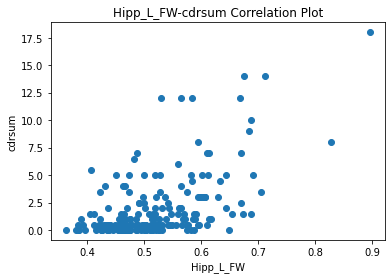

In [28]:
def plot_corr(field_x,field_y):
    plt.scatter(data_clean[field_x],data_clean[field_y])
    plt.title(field_x+'-'+field_y+' Correlation Plot')
    plt.xlabel(field_x)
    plt.ylabel(field_y)
    return

plot_corr('Hipp_L_FW','cdrsum')

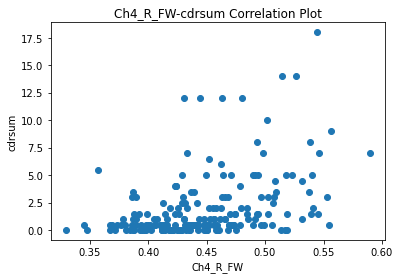

In [29]:
plot_corr('Ch4_R_FW','cdrsum')

### Between-group tests

In [30]:
def run_ttest(grp1,grp2,field):
    return stats.ttest_ind(data_clean.loc[data_clean.lrnDiag == grp1,[field]], data_clean.loc[data_clean.lrnDiag == grp2,[field]], equal_var=False).pvalue[0]

def ttest_and_plot(field):
    # Run ANCOVA
    display(pg.ancova(data=data_clean2, dv=field, covar=['imgAge','sex','educ','apoe'], between='lrnDiag'))
    
    # Run post-hoc tests
    d = [['CN-EMCI',run_ttest('1CN','2EMCI',field)],
        ['CN-LMCI',run_ttest('1CN','3LMCI',field)],
        ['CN-AD',run_ttest('1CN','4AD',field)],
        ['EMCI-LMCI',run_ttest('2EMCI','3LMCI',field)],
        ['EMCI-AD',run_ttest('2EMCI','4AD',field)],
        ['LMCI-AD',run_ttest('3LMCI','4AD',field)]]
    
    df = pd.DataFrame(d, columns = ['Comparison','tt_pval'])
    df = df.style.apply(lambda x: ['background-color: yellow','background-color: yellow'] if x.tt_pval < 0.05 else ['background-color: white','background-color: white'], axis=1)
    display(df)
    
    # Output boxplot
    data_clean.boxplot(column=field,by='lrnDiag')
    return

,Source,SS,DF,F,p-unc,np2
0,lrnDiag,0.050507,3,5.838235,8.951238e-04,0.117932
1,imgAge,0.137635,1,47.728428,1.919654e-10,0.267044
2,sex,0.019646,1,6.812714,1.010505e-02,0.049435
3,educ,0.006976,1,2.418978,1.222858e-01,0.018131
4,apoe,0.008442,1,2.927306,8.945961e-02,0.021857
5,Residual,0.377767,131,NaN,NaN,NaN


,Comparison,tt_pval
0,CN-EMCI,0.086902
1,CN-LMCI,0.084456
2,CN-AD,0.000149
3,EMCI-LMCI,0.624037
4,EMCI-AD,0.003986
5,LMCI-AD,0.052390


C:\Users\wc11\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


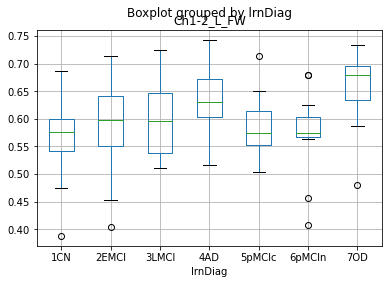

In [31]:
ttest_and_plot('Ch1-2_L_FW')

,Source,SS,DF,F,p-unc,np2
0,lrnDiag,0.058646,3,6.528936,3.773670e-04,0.130070
1,imgAge,0.152579,1,50.958453,5.806488e-11,0.280055
2,sex,0.023790,1,7.945516,5.569291e-03,0.057184
3,educ,0.003916,1,1.307900,2.548608e-01,0.009885
4,apoe,0.002351,1,0.785289,3.771522e-01,0.005959
5,Residual,0.392238,131,NaN,NaN,NaN


,Comparison,tt_pval
0,CN-EMCI,0.134775
1,CN-LMCI,0.121193
2,CN-AD,0.000137
3,EMCI-LMCI,0.573864
4,EMCI-AD,0.001538
5,LMCI-AD,0.049501


C:\Users\wc11\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


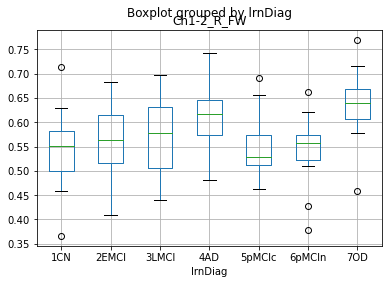

In [32]:
ttest_and_plot('Ch1-2_R_FW')

,Source,SS,DF,F,p-unc,np2
0,lrnDiag,0.045422,3,4.428873,0.005325,0.092085
1,imgAge,0.032975,1,9.645650,0.002327,0.068581
2,sex,0.002492,1,0.728972,0.394775,0.005534
3,educ,0.008259,1,2.415919,0.122520,0.018108
4,apoe,0.000147,1,0.043082,0.835893,0.000329
5,Residual,0.447845,131,NaN,NaN,NaN


,Comparison,tt_pval
0,CN-EMCI,0.111272
1,CN-LMCI,0.300817
2,CN-AD,0.001516
3,EMCI-LMCI,0.997822
4,EMCI-AD,0.015623
5,LMCI-AD,0.064735


C:\Users\wc11\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


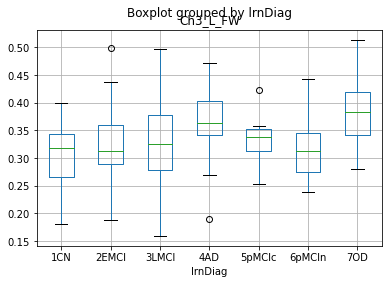

In [33]:
ttest_and_plot('Ch3_L_FW')

,Source,SS,DF,F,p-unc,np2
0,lrnDiag,0.019327,3,2.533366,0.059762,0.054835
1,imgAge,0.029681,1,11.671885,0.000846,0.081809
2,sex,0.019088,1,7.506241,0.007006,0.054194
3,educ,0.005286,1,2.078540,0.151769,0.015619
4,apoe,0.000105,1,0.041333,0.839212,0.000315
5,Residual,0.333129,131,NaN,NaN,NaN


,Comparison,tt_pval
0,CN-EMCI,0.103042
1,CN-LMCI,0.341145
2,CN-AD,0.014813
3,EMCI-LMCI,0.912810
4,EMCI-AD,0.112729
5,LMCI-AD,0.183748


C:\Users\wc11\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


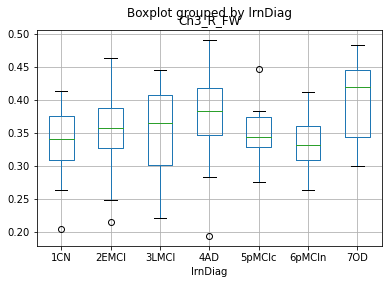

In [34]:
ttest_and_plot('Ch3_R_FW')

,Source,SS,DF,F,p-unc,np2
0,lrnDiag,0.069638,3,11.896782,6.109891e-07,0.214112
1,imgAge,0.073204,1,37.518054,9.859660e-09,0.222635
2,sex,0.010173,1,5.213905,2.401698e-02,0.038277
3,educ,0.002242,1,1.149044,2.857201e-01,0.008695
4,apoe,0.000422,1,0.216422,6.425520e-01,0.001649
5,Residual,0.255604,131,NaN,NaN,NaN


,Comparison,tt_pval
0,CN-EMCI,0.052702
1,CN-LMCI,0.013962
2,CN-AD,0.000016
3,EMCI-LMCI,0.242816
4,EMCI-AD,0.000385
5,LMCI-AD,0.012595


C:\Users\wc11\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


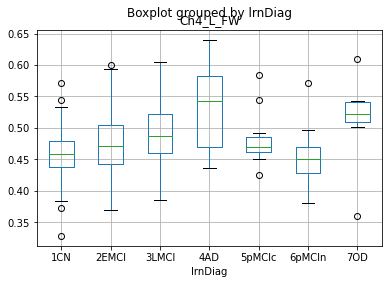

In [35]:
ttest_and_plot('Ch4_L_FW')

,Source,SS,DF,F,p-unc,np2
0,lrnDiag,0.058069,3,13.146970,1.475327e-07,0.231405
1,imgAge,0.052749,1,35.827387,1.941051e-08,0.214757
2,sex,0.006928,1,4.705660,3.186854e-02,0.034675
3,educ,0.001857,1,1.261599,2.634029e-01,0.009539
4,apoe,0.001795,1,1.219034,2.715743e-01,0.009220
5,Residual,0.192872,131,NaN,NaN,NaN


,Comparison,tt_pval
0,CN-EMCI,0.019720
1,CN-LMCI,0.012805
2,CN-AD,0.000000
3,EMCI-LMCI,0.355714
4,EMCI-AD,0.000048
5,LMCI-AD,0.005888


C:\Users\wc11\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


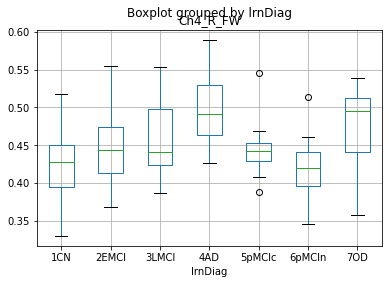

In [36]:
ttest_and_plot('Ch4_R_FW')

,Source,SS,DF,F,p-unc,np2
0,lrnDiag,0.026161,3,4.550121,0.004564,0.094368
1,imgAge,0.000279,1,0.145773,0.703227,0.001112
2,sex,0.000608,1,0.317200,0.574258,0.002416
3,educ,0.000308,1,0.160456,0.689390,0.001223
4,apoe,0.002003,1,1.045252,0.308487,0.007916
5,Residual,0.251058,131,NaN,NaN,NaN


,Comparison,tt_pval
0,CN-EMCI,0.197339
1,CN-LMCI,0.022815
2,CN-AD,0.004414
3,EMCI-LMCI,0.102331
4,EMCI-AD,0.021992
5,LMCI-AD,0.525378


C:\Users\wc11\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


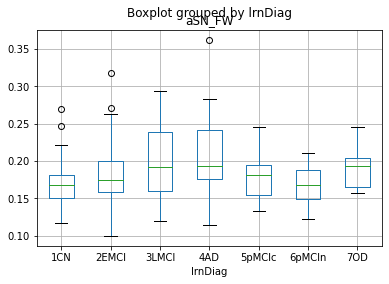

In [37]:
ttest_and_plot('aSN_FW')

,Source,SS,DF,F,p-unc,np2
0,lrnDiag,0.013094,3,2.206212,0.090402,0.048094
1,imgAge,0.018051,1,9.124575,0.003033,0.065118
2,sex,0.000010,1,0.005117,0.943085,0.000039
3,educ,0.000764,1,0.386216,0.535375,0.002940
4,apoe,0.000074,1,0.037325,0.847104,0.000285
5,Residual,0.259156,131,NaN,NaN,NaN


,Comparison,tt_pval
0,CN-EMCI,0.237464
1,CN-LMCI,0.029371
2,CN-AD,0.074855
3,EMCI-LMCI,0.108553
4,EMCI-AD,0.235159
5,LMCI-AD,0.842586


C:\Users\wc11\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


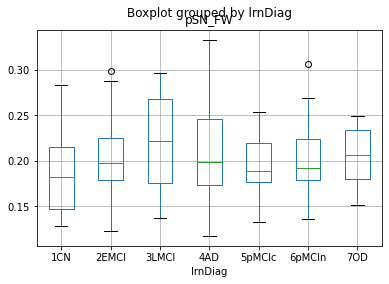

In [38]:
ttest_and_plot('pSN_FW')

,Source,SS,DF,F,p-unc,np2
0,lrnDiag,0.020807,3,8.928143,0.000020,0.169753
1,imgAge,0.016379,1,21.084574,0.000010,0.138637
2,sex,0.002162,1,2.782500,0.097688,0.020799
3,educ,0.000041,1,0.053153,0.818025,0.000406
4,apoe,0.000461,1,0.592851,0.442705,0.004505
5,Residual,0.101766,131,NaN,NaN,NaN


,Comparison,tt_pval
0,CN-EMCI,0.146727
1,CN-LMCI,0.014297
2,CN-AD,0.000679
3,EMCI-LMCI,0.117180
4,EMCI-AD,0.003542
5,LMCI-AD,0.047506


C:\Users\wc11\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


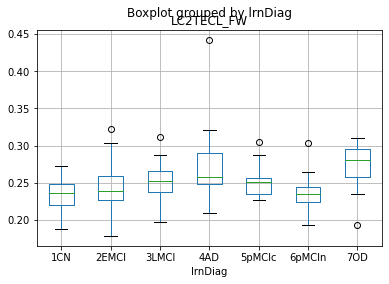

In [39]:
ttest_and_plot('LC2TECL_FW')

,Source,SS,DF,F,p-unc,np2
0,lrnDiag,0.027101,3,12.150941,4.566443e-07,0.217690
1,imgAge,0.023254,1,31.278216,1.248703e-07,0.192744
2,sex,0.000616,1,0.828444,3.643945e-01,0.006284
3,educ,0.000190,1,0.255000,6.144245e-01,0.001943
4,apoe,0.000036,1,0.048195,8.265762e-01,0.000368
5,Residual,0.097391,131,NaN,NaN,NaN


,Comparison,tt_pval
0,CN-EMCI,0.035808
1,CN-LMCI,0.006829
2,CN-AD,0.000169
3,EMCI-LMCI,0.125860
4,EMCI-AD,0.001813
5,LMCI-AD,0.040122


C:\Users\wc11\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


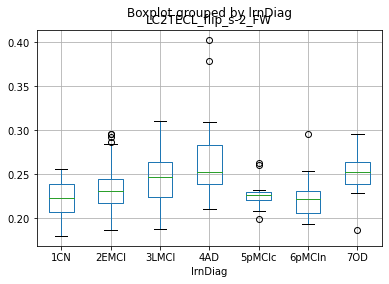

In [40]:
ttest_and_plot('LC2TECL_flip_s-2_FW')

,Source,SS,DF,F,p-unc,np2
0,lrnDiag,0.188654,3,16.803777,2.703861e-09,0.277884
1,imgAge,0.160036,1,42.764004,1.262778e-09,0.246104
2,sex,0.029948,1,8.002473,5.406699e-03,0.057571
3,educ,0.011842,1,3.164324,7.758286e-02,0.023585
4,apoe,0.006387,1,1.706779,1.936929e-01,0.012861
5,Residual,0.490241,131,NaN,NaN,NaN


,Comparison,tt_pval
0,CN-EMCI,0.002630
1,CN-LMCI,0.000147
2,CN-AD,0.000005
3,EMCI-LMCI,0.039375
4,EMCI-AD,0.000492
5,LMCI-AD,0.051525


C:\Users\wc11\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


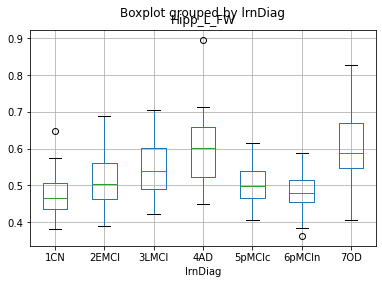

In [41]:
ttest_and_plot('Hipp_L_FW')

,Source,SS,DF,F,p-unc,np2
0,lrnDiag,0.180802,3,20.694411,4.879777e-11,0.321536
1,imgAge,0.160191,1,55.005967,1.339161e-11,0.295722
2,sex,0.030902,1,10.610991,1.431698e-03,0.074931
3,educ,0.003647,1,1.252246,2.651716e-01,0.009469
4,apoe,0.000745,1,0.255968,6.137544e-01,0.001950
5,Residual,0.381505,131,NaN,NaN,NaN


,Comparison,tt_pval
0,CN-EMCI,0.012006
1,CN-LMCI,0.000190
2,CN-AD,0.000002
3,EMCI-LMCI,0.021403
4,EMCI-AD,0.000120
5,LMCI-AD,0.028482


C:\Users\wc11\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


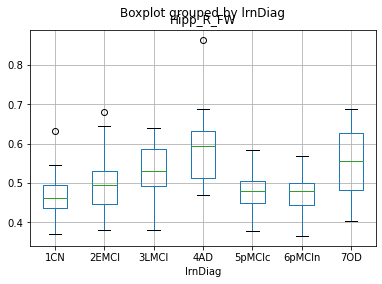

In [42]:
ttest_and_plot('Hipp_R_FW')

,Source,SS,DF,F,p-unc,np2
0,lrnDiag,0.004961,3,5.273299,0.001824,0.107750
1,imgAge,0.006106,1,19.471083,0.000021,0.129401
2,sex,0.000673,1,2.145127,0.145419,0.016111
3,educ,0.000034,1,0.109515,0.741226,0.000835
4,apoe,0.000050,1,0.160290,0.689542,0.001222
5,Residual,0.041080,131,NaN,NaN,NaN


,Comparison,tt_pval
0,CN-EMCI,0.438989
1,CN-LMCI,0.083341
2,CN-AD,0.001429
3,EMCI-LMCI,0.203840
4,EMCI-AD,0.003394
5,LMCI-AD,0.087618


C:\Users\wc11\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


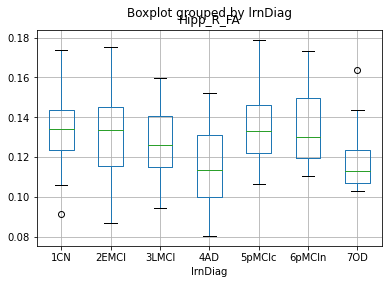

In [43]:
ttest_and_plot('Hipp_R_FA')

#### ANCOVA Results Table
* SS = Sums of squares
* DF = Degrees of freedom
* F = F-values
* p-unc = Uncorrected p-values
* np2 = Partial eta-squared

In [44]:
print(data_clean.columns)

Index(['Subject', 'aSN_FW', 'pSN_FW', 'LC2TECL_flip_s-2_FW', 'LC2TECL_FW',
       'Ch1-2_L_FW', 'Ch1-2_R_FW', 'Ch3_L_FW', 'Ch3_R_FW', 'Ch4_L_FW',
       'Ch4_R_FW', 'Ch4p_L_FW', 'Ch4p_R_FW', 'Hipp_L_FW', 'Hipp_R_FW',
       'aSN_FA', 'pSN_FA', 'LC2TECL_flip_s-2_FA', 'LC2TECL_FA', 'Ch1-2_L_FA',
       'Ch1-2_R_FA', 'Ch3_L_FA', 'Ch3_R_FA', 'Ch4_L_FA', 'Ch4_R_FA',
       'Ch4p_L_FA', 'Ch4p_R_FA', 'Hipp_L_FA', 'Hipp_R_FA', 'aSN_MD', 'pSN_MD',
       'LC2TECL_flip_s-2_MD', 'LC2TECL_MD', 'Ch1-2_L_MD', 'Ch1-2_R_MD',
       'Ch3_L_MD', 'Ch3_R_MD', 'Ch4_L_MD', 'Ch4_R_MD', 'Ch4p_L_MD',
       'Ch4p_R_MD', 'Hipp_L_MD', 'Hipp_R_MD', 'month', 'day', 'year',
       'imgDate', 'lrnDiag', 'birthyr', 'sex', 'educ', 'apoe', 'mocatots',
       'amylcsf', 'csftau', 'cdrsum', 'lrnMMSE', 'NFL', 'abeta40_plasma_ipms',
       'abeta42_plasma_ipms', 'abeta4240_plasma_ipms', 'fl9_lassi_delayed_raw',
       'fl9_lassi_delayed_no', 'imgAge'],
      dtype='object')


In [45]:
data_clean

,Subject,aSN_FW,pSN_FW,LC2TECL_flip_s-2_FW,LC2TECL_FW,Ch1-2_L_FW,Ch1-2_R_FW,Ch3_L_FW,Ch3_R_FW,Ch4_L_FW,...,csftau,cdrsum,lrnMMSE,NFL,abeta40_plasma_ipms,abeta42_plasma_ipms,abeta4240_plasma_ipms,fl9_lassi_delayed_raw,fl9_lassi_delayed_no,imgAge
ptid,,,,,,,,,,,,,,,,,,,,,
110004,110004_02152017,0.128303,0.193216,0.240536,0.254672,0.584820,0.557282,0.341721,0.361127,0.465050,...,8.0,0.5,29.0,39.0,NaN,NaN,NaN,NaN,NaN,77.0
110005,110005_02152017,0.172525,0.199825,0.222260,0.304831,0.714482,0.691253,0.422676,0.377966,0.584305,...,8.0,1.0,29.0,10.0,NaN,NaN,NaN,NaN,NaN,76.0
110010,110010_01272017,0.182952,0.218979,0.234071,0.236581,0.610491,0.605493,0.300395,0.321008,0.493928,...,8.0,2.0,28.0,20.0,NaN,NaN,NaN,15.0,1.0,75.0
110014,110014_01172017,0.208020,0.270705,0.222919,0.256869,0.585111,0.556794,0.340725,0.313168,0.478893,...,8.0,0.0,28.0,21.3,NaN,NaN,NaN,19.0,1.0,77.0
110015,110015_02242017,0.182364,0.204380,0.250675,0.221551,0.623444,0.587679,0.324246,0.347763,0.457309,...,8.0,0.0,30.0,19.6,NaN,NaN,NaN,NaN,NaN,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110323,MR5063_11282017,0.130926,0.172525,0.214395,0.231112,0.582650,0.534842,0.344794,0.342994,0.409127,...,8.0,1.5,30.0,26.9,NaN,NaN,NaN,14.0,2.0,71.0
110365,MR5066_09262018,0.168386,0.262820,0.242495,0.272440,0.585150,0.581057,0.318131,0.385482,0.544897,...,8.0,0.0,30.0,NaN,NaN,NaN,NaN,19.0,0.0,68.0
110359,MR5067_11072018,0.271090,0.184493,0.224435,0.228155,0.529324,0.541940,0.309159,0.360305,0.468867,...,8.0,0.5,28.0,12.2,NaN,NaN,NaN,NaN,NaN,65.0


### Create ML models to predict diagnosis based on imaging

In [46]:
def test_models(X,y):
    #Runs standard machine learning
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    print('SVM, linear kernel')
    svclassifier = SVC(kernel='linear')
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))

    print('--------------------------------------------------------')

    print('SVM, polynomial kernel')
    svclassifier = SVC(kernel='poly', degree=8)
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))

    print('--------------------------------------------------------')

    print('SVM, Gaussian kernel')
    svclassifier = SVC(kernel='rbf') #Gaussian Kernel
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))

    print('--------------------------------------------------------')

    print('Decision Tree')
    classifier = DecisionTreeClassifier()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))

    print('--------------------------------------------------------')
    print('Linear Regression')
    classifier = LinearRegression()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    # The coefficients
    print('Coefficients: \n', classifier.coef_)
    # The mean squared error
    print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))
    #print(confusion_matrix(y_test,y_pred))
    #print(classification_report(y_test,y_pred))
    

In [47]:
def cross_val_ML(X,y):
    # Runs machine learning with cross-validation
    
    print('5-fold stratified cross-validation of decision tree')
    classifier = DecisionTreeClassifier()
    scores = cross_val_score(classifier, X, y, cv=20)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    print('--------------------------------------------------------')

    print('5-fold stratified cross-validation of SVM')
    classifier = SVC(kernel='linear')
    scores = cross_val_score(classifier, X, y, cv=20)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    print('--------------------------------------------------------')
    
    print('5-fold stratified cross-validation of linear regression')
    classifier = LinearRegression()
    scores = cross_val_score(classifier, X, y, cv=20)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    print('--------------------------------------------------------')
    
    print('Shuffle-split cross validation of decision tree')
    clf = DecisionTreeClassifier()
    cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
    scores = cross_val_score(clf, X, y, cv=cv)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [48]:
def ml_test(CN,EMCI,LMCI,AD,pMCIc,pMCIn,OD):
    # Inputs: enumerate each group or set to None to exclude group
    
    data_SVM_pre = data_clean[['Ch1-2_L_FW','Ch1-2_R_FW',
                        'Ch3_L_FW','Ch3_R_FW',
                        'Ch4_L_FW','Ch4_R_FW',
                        'Ch4p_L_FW','Ch4p_R_FW',
                        'Hipp_L_FW','Hipp_R_FW',
                        'LC2TECL_FW','LC2TECL_flip_s-2_FW',
                        'lrnDiag']].copy()

    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '1CN','lrnDiag'] = CN
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '2EMCI','lrnDiag'] = EMCI
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '3LMCI','lrnDiag'] = LMCI
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '4AD','lrnDiag'] = AD
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '5pMCIc','lrnDiag'] = pMCIc
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '6pMCIn','lrnDiag'] = pMCIn
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '7OD','lrnDiag'] = OD
    data_SVM_pre = data_SVM_pre.dropna()

    X = data_SVM_pre[['Ch1-2_L_FW','Ch1-2_R_FW',
                        'Ch3_L_FW','Ch3_R_FW',
                        'Ch4_L_FW','Ch4_R_FW',
                        'Ch4p_L_FW','Ch4p_R_FW',
                        'Hipp_L_FW','Hipp_R_FW',
                        'LC2TECL_FW','LC2TECL_flip_s-2_FW']]
    y = data_SVM_pre['lrnDiag'].astype(int)
    
    test_models(X,y)
    print('---------------------------------')
    print('Cross-validation models')
    print('---------------------------------')
    cross_val_ML(X,y)

In [49]:
print('CN-EMCI-LMCI-AD')
ml_test(1,2,3,4,None,None,None)

CN-EMCI-LMCI-AD
SVM, linear kernel
[[ 0  7  0  0]
 [ 0 15  0  0]
 [ 0  6  0  0]
 [ 0  3  0  0]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         7
          2       0.48      1.00      0.65        15
          3       0.00      0.00      0.00         6
          4       0.00      0.00      0.00         3

avg / total       0.23      0.48      0.32        31

--------------------------------------------------------
SVM, polynomial kernel
[[ 0  7  0  0]
 [ 0 15  0  0]
 [ 0  6  0  0]
 [ 0  3  0  0]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         7
          2       0.48      1.00      0.65        15
          3       0.00      0.00      0.00         6
          4       0.00      0.00      0.00         3

avg / total       0.23      0.48      0.32        31

--------------------------------------------------------
SVM, Gaussian kernel
[[ 0  7  0  0]
 [ 0 15  0  0]
 [ 0  6  0  0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.50 (+/- 0.11)
--------------------------------------------------------
5-fold stratified cross-validation of linear regression
Accuracy: -0.50 (+/- 4.11)
--------------------------------------------------------
Shuffle-split cross validation of decision tree
Accuracy: 0.37 (+/- 0.18)


In [50]:
print('CN-EMCI,LMCI,AD')
ml_test(1,2,2,2,None,None,None)

CN-EMCI,LMCI,AD
SVM, linear kernel
[[ 0  7]
 [ 0 24]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         7
          2       0.77      1.00      0.87        24

avg / total       0.60      0.77      0.68        31

--------------------------------------------------------
SVM, polynomial kernel
[[ 0  7]
 [ 0 24]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         7
          2       0.77      1.00      0.87        24

avg / total       0.60      0.77      0.68        31

--------------------------------------------------------
SVM, Gaussian kernel
[[ 0  7]
 [ 0 24]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         7
          2       0.77      1.00      0.87        24

avg / total       0.60      0.77      0.68        31

--------------------------------------------------------
Decision Tree
[[ 1  6]
 [ 6 18]]
             pr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: -0.10 (+/- 0.65)
--------------------------------------------------------
Shuffle-split cross validation of decision tree
Accuracy: 0.67 (+/- 0.16)


In [51]:
print('CN,EMCI,LMCI-AD')
ml_test(1,1,1,2,None,None,None)

CN,EMCI,LMCI-AD
SVM, linear kernel
[[28  0]
 [ 3  0]]
             precision    recall  f1-score   support

          1       0.90      1.00      0.95        28
          2       0.00      0.00      0.00         3

avg / total       0.82      0.90      0.86        31

--------------------------------------------------------
SVM, polynomial kernel
[[28  0]
 [ 3  0]]
             precision    recall  f1-score   support

          1       0.90      1.00      0.95        28
          2       0.00      0.00      0.00         3

avg / total       0.82      0.90      0.86        31

--------------------------------------------------------
SVM, Gaussian kernel
[[28  0]
 [ 3  0]]
             precision    recall  f1-score   support

          1       0.90      1.00      0.95        28
          2       0.00      0.00      0.00         3

avg / total       0.82      0.90      0.86        31

--------------------------------------------------------
Decision Tree
[[23  5]
 [ 2  1]]
             pr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.85 (+/- 0.07)
--------------------------------------------------------
5-fold stratified cross-validation of linear regression
Accuracy: 0.03 (+/- 0.81)
--------------------------------------------------------
Shuffle-split cross validation of decision tree
Accuracy: 0.79 (+/- 0.11)


In [52]:
print('CN,EMCI-LMCI,AD')
ml_test(1,1,2,2,None,None,None)

CN,EMCI-LMCI,AD
SVM, linear kernel
[[20  0]
 [11  0]]
             precision    recall  f1-score   support

          1       0.65      1.00      0.78        20
          2       0.00      0.00      0.00        11

avg / total       0.42      0.65      0.51        31

--------------------------------------------------------
SVM, polynomial kernel
[[20  0]
 [11  0]]
             precision    recall  f1-score   support

          1       0.65      1.00      0.78        20
          2       0.00      0.00      0.00        11

avg / total       0.42      0.65      0.51        31

--------------------------------------------------------
SVM, Gaussian kernel
[[20  0]
 [11  0]]
             precision    recall  f1-score   support

          1       0.65      1.00      0.78        20
          2       0.00      0.00      0.00        11

avg / total       0.42      0.65      0.51        31

--------------------------------------------------------
Decision Tree
[[17  3]
 [ 4  7]]
             pr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: -0.09 (+/- 1.11)
--------------------------------------------------------
Shuffle-split cross validation of decision tree
Accuracy: 0.65 (+/- 0.08)


In [53]:
print('CN-EMCI-LMCI-AD-pMCIc')
ml_test(1,3,4,5,2,None,None)

CN-EMCI-LMCI-AD-pMCIc
SVM, linear kernel
[[ 0  0  4  0  0]
 [ 0  0  5  0  0]
 [ 0  0 14  0  0]
 [ 0  0  6  0  0]
 [ 0  0  5  0  0]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         4
          2       0.00      0.00      0.00         5
          3       0.41      1.00      0.58        14
          4       0.00      0.00      0.00         6
          5       0.00      0.00      0.00         5

avg / total       0.17      0.41      0.24        34

--------------------------------------------------------
SVM, polynomial kernel
[[ 0  0  4  0  0]
 [ 0  0  5  0  0]
 [ 0  0 14  0  0]
 [ 0  0  6  0  0]
 [ 0  0  5  0  0]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         4
          2       0.00      0.00      0.00         5
          3       0.41      1.00      0.58        14
          4       0.00      0.00      0.00         6
          5       0.00      0.00      0.00         5

avg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 15 members, which is too few. The minimum number of members in any class cannot be less than n_splits=20.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 15 members, which is too few. The minimum number of members in any class cannot be less than n_splits=20.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.46 (+/- 0.12)
--------------------------------------------------------
5-fold stratified cross-validation of linear regression
Accuracy: -0.28 (+/- 1.72)
--------------------------------------------------------
Shuffle-split cross validation of decision tree
Accuracy: 0.33 (+/- 0.15)


### Try reducing dimensionality by combining Left and Right

In [54]:
def ml_test_short(CN,EMCI,LMCI,AD,pMCIc,pMCIn,OD):
    # Inputs: enumerate each group or set to None to exclude group
    
    data_SVM_pre = data_clean[['Ch1-2_L_FW','Ch1-2_R_FW',
                        'Ch3_L_FW','Ch3_R_FW',
                        'Ch4_L_FW','Ch4_R_FW',
                        'Ch4p_L_FW','Ch4p_R_FW',
                        'Hipp_L_FW','Hipp_R_FW',
                        'LC2TECL_FW','LC2TECL_flip_s-2_FW',
                        'lrnDiag']].copy()
    
    #Calculate average of left and right to reduce dimensionality
    data_SVM_pre['Ch1-2_FW'] = (data_SVM_pre['Ch1-2_L_FW']+data_SVM_pre['Ch1-2_R_FW'])/2
    data_SVM_pre['Ch3_FW'] = (data_SVM_pre['Ch3_L_FW']+data_SVM_pre['Ch3_R_FW'])/2
    data_SVM_pre['Ch4_FW'] = (data_SVM_pre['Ch4_L_FW']+data_SVM_pre['Ch4_R_FW'])/2
    data_SVM_pre['Ch4p_FW'] = (data_SVM_pre['Ch4p_L_FW']+data_SVM_pre['Ch4p_R_FW'])/2
    data_SVM_pre['Hipp_FW'] = (data_SVM_pre['Hipp_L_FW']+data_SVM_pre['Hipp_R_FW'])/2
    data_SVM_pre['LC2TEC_FW'] = (data_SVM_pre['LC2TECL_FW']+data_SVM_pre['LC2TECL_flip_s-2_FW'])/2
    
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '1CN','lrnDiag'] = CN
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '2EMCI','lrnDiag'] = EMCI
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '3LMCI','lrnDiag'] = LMCI
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '4AD','lrnDiag'] = AD
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '5pMCIc','lrnDiag'] = pMCIc
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '6pMCIn','lrnDiag'] = pMCIn
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '7OD','lrnDiag'] = OD
    data_SVM_pre = data_SVM_pre.dropna()

    X = data_SVM_pre[['Ch1-2_FW',
                        'Ch3_FW',
                        'Ch4_FW',
                        'Ch4p_FW',
                        'Hipp_FW',
                        'LC2TEC_FW']]
    y = data_SVM_pre['lrnDiag'].astype(int)
    
    test_models(X,y)
    print('---------------------------------')
    print('Cross-validation models')
    print('---------------------------------')
    cross_val_ML(X,y)

In [55]:
print('CN-EMCI-LMCI-AD')
ml_test_short(1,2,3,4,None,None,None)

CN-EMCI-LMCI-AD
SVM, linear kernel
[[ 0  7  0  0]
 [ 0 17  0  0]
 [ 0  4  0  0]
 [ 0  3  0  0]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         7
          2       0.55      1.00      0.71        17
          3       0.00      0.00      0.00         4
          4       0.00      0.00      0.00         3

avg / total       0.30      0.55      0.39        31

--------------------------------------------------------
SVM, polynomial kernel
[[ 0  7  0  0]
 [ 0 17  0  0]
 [ 0  4  0  0]
 [ 0  3  0  0]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         7
          2       0.55      1.00      0.71        17
          3       0.00      0.00      0.00         4
          4       0.00      0.00      0.00         3

avg / total       0.30      0.55      0.39        31

--------------------------------------------------------
SVM, Gaussian kernel
[[ 0  7  0  0]
 [ 0 17  0  0]
 [ 0  4  0  0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.50 (+/- 0.11)
--------------------------------------------------------
5-fold stratified cross-validation of linear regression
Accuracy: -0.43 (+/- 3.32)
--------------------------------------------------------
Shuffle-split cross validation of decision tree
Accuracy: 0.42 (+/- 0.22)


In [56]:
print('CN-EMCI,LMCI,AD')
ml_test_short(1,2,2,2,None,None,None)

CN-EMCI,LMCI,AD
SVM, linear kernel
[[ 0  6]
 [ 0 25]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         6
          2       0.81      1.00      0.89        25

avg / total       0.65      0.81      0.72        31

--------------------------------------------------------
SVM, polynomial kernel
[[ 0  6]
 [ 0 25]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         6
          2       0.81      1.00      0.89        25

avg / total       0.65      0.81      0.72        31

--------------------------------------------------------
SVM, Gaussian kernel
[[ 0  6]
 [ 0 25]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         6
          2       0.81      1.00      0.89        25

avg / total       0.65      0.81      0.72        31

--------------------------------------------------------
Decision Tree
[[ 3  3]
 [ 6 19]]
             pr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: -0.09 (+/- 0.52)
--------------------------------------------------------
Shuffle-split cross validation of decision tree
Accuracy: 0.72 (+/- 0.17)


In [57]:
print('CN,EMCI,LMCI-AD')
ml_test_short(1,1,1,2,None,None,None)

CN,EMCI,LMCI-AD
SVM, linear kernel
[[24  0]
 [ 7  0]]
             precision    recall  f1-score   support

          1       0.77      1.00      0.87        24
          2       0.00      0.00      0.00         7

avg / total       0.60      0.77      0.68        31

--------------------------------------------------------
SVM, polynomial kernel
[[24  0]
 [ 7  0]]
             precision    recall  f1-score   support

          1       0.77      1.00      0.87        24
          2       0.00      0.00      0.00         7

avg / total       0.60      0.77      0.68        31

--------------------------------------------------------
SVM, Gaussian kernel
[[24  0]
 [ 7  0]]
             precision    recall  f1-score   support

          1       0.77      1.00      0.87        24
          2       0.00      0.00      0.00         7

avg / total       0.60      0.77      0.68        31

--------------------------------------------------------
Decision Tree
[[21  3]
 [ 4  3]]
             pr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.85 (+/- 0.07)
--------------------------------------------------------
5-fold stratified cross-validation of linear regression
Accuracy: 0.05 (+/- 0.60)
--------------------------------------------------------
Shuffle-split cross validation of decision tree
Accuracy: 0.78 (+/- 0.10)


In [58]:
def ml_test_Vshort(CN,EMCI,LMCI,AD,pMCIc,pMCIn,OD):
    # Inputs: enumerate each group or set to None to exclude group
    
    data_SVM_pre = data_clean[['Hipp_L_FW','Hipp_R_FW','lrnDiag']].copy()
    
    #Calculate average of left and right to reduce dimensionality
    data_SVM_pre['Hipp_FW'] = (data_SVM_pre['Hipp_L_FW']+data_SVM_pre['Hipp_R_FW'])/2
    
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '1CN','lrnDiag'] = CN
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '2EMCI','lrnDiag'] = EMCI
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '3LMCI','lrnDiag'] = LMCI
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '4AD','lrnDiag'] = AD
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '5pMCIc','lrnDiag'] = pMCIc
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '6pMCIn','lrnDiag'] = pMCIn
    data_SVM_pre.loc[data_SVM_pre.lrnDiag == '7OD','lrnDiag'] = OD
    data_SVM_pre = data_SVM_pre.dropna()

    X = data_SVM_pre[['Hipp_FW']]
    y = data_SVM_pre['lrnDiag'].astype(int)
    
    test_models(X,y)
    print('---------------------------------')
    print('Cross-validation models')
    print('---------------------------------')
    cross_val_ML(X,y)

In [59]:
print('CN-EMCI-LMCI-AD')
ml_test_Vshort(1,2,3,4,None,None,None)

CN-EMCI-LMCI-AD
SVM, linear kernel
[[ 0  6  0  0]
 [ 0 13  0  0]
 [ 0  6  0  0]
 [ 0  6  0  0]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         6
          2       0.42      1.00      0.59        13
          3       0.00      0.00      0.00         6
          4       0.00      0.00      0.00         6

avg / total       0.18      0.42      0.25        31

--------------------------------------------------------
SVM, polynomial kernel
[[ 0  6  0  0]
 [ 0 13  0  0]
 [ 0  6  0  0]
 [ 0  6  0  0]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         6
          2       0.42      1.00      0.59        13
          3       0.00      0.00      0.00         6
          4       0.00      0.00      0.00         6

avg / total       0.18      0.42      0.25        31

--------------------------------------------------------
SVM, Gaussian kernel
[[ 0  6  0  0]
 [ 0 13  0  0]
 [ 0  6  0  0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.50 (+/- 0.11)
--------------------------------------------------------
5-fold stratified cross-validation of linear regression
Accuracy: -0.29 (+/- 2.68)
--------------------------------------------------------
Shuffle-split cross validation of decision tree
Accuracy: 0.34 (+/- 0.14)


In [60]:
print('CN-EMCI,LMCI,AD')
ml_test_Vshort(1,2,2,2,None,None,None)

CN-EMCI,LMCI,AD
SVM, linear kernel
[[ 0  8]
 [ 0 23]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         8
          2       0.74      1.00      0.85        23

avg / total       0.55      0.74      0.63        31

--------------------------------------------------------
SVM, polynomial kernel
[[ 0  8]
 [ 0 23]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         8
          2       0.74      1.00      0.85        23

avg / total       0.55      0.74      0.63        31

--------------------------------------------------------
SVM, Gaussian kernel
[[ 0  8]
 [ 0 23]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         8
          2       0.74      1.00      0.85        23

avg / total       0.55      0.74      0.63        31

--------------------------------------------------------
Decision Tree
[[ 4  4]
 [ 3 20]]
             pr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: -0.01 (+/- 0.39)
--------------------------------------------------------
Shuffle-split cross validation of decision tree
Accuracy: 0.75 (+/- 0.13)


In [61]:
print('CN,EMCI,LMCI-AD')
ml_test_Vshort(1,1,1,2,None,None,None)

CN,EMCI,LMCI-AD
SVM, linear kernel
[[27  0]
 [ 4  0]]
             precision    recall  f1-score   support

          1       0.87      1.00      0.93        27
          2       0.00      0.00      0.00         4

avg / total       0.76      0.87      0.81        31

--------------------------------------------------------
SVM, polynomial kernel
[[27  0]
 [ 4  0]]
             precision    recall  f1-score   support

          1       0.87      1.00      0.93        27
          2       0.00      0.00      0.00         4

avg / total       0.76      0.87      0.81        31

--------------------------------------------------------
SVM, Gaussian kernel
[[27  0]
 [ 4  0]]
             precision    recall  f1-score   support

          1       0.87      1.00      0.93        27
          2       0.00      0.00      0.00         4

avg / total       0.76      0.87      0.81        31

--------------------------------------------------------
Decision Tree
[[24  3]
 [ 1  3]]
             pr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.06 (+/- 0.54)
--------------------------------------------------------
Shuffle-split cross validation of decision tree
Accuracy: 0.79 (+/- 0.14)


In [62]:
#corr_array = data_clean.corr(method='spearman')[['mocatots','cdrsum','ave_conc','lrnMMSE',
#                                                 'fl9_lassi_delayed_raw','fl9_lassi_delayed_no']]
#corr_array = corr_array.loc[['Ch1-2_L_FW','Ch1-2_R_FW',
#                             'Ch3_L_FW','Ch3_R_FW',
#                             'Ch4_L_FW','Ch4_R_FW',
#                             'Ch4p_L_FW','Ch4p_R_FW',
#                             'Hipp_L_FW','Hipp_R_FW',
#                             'LC2TECL_FW','LC2TECL_flip_s-2_FW',
#                             'aSN_FW','pSN_FW']]
#pg.corr(x=data_clean['Ch1-2_L_FW'],y=data_clean['mocatots'])

#.sort_values(by=['p-unc'])[['X', 'Y', 'n', 'r', 'p-unc']]
#display(corr_array)
#plt.scatter(data_clean[field_x],data_clean[field_y])
#plt.title(field_x+'-'+field_y+' Correlation Plot')
#plt.xlabel(field_x)
#plt.ylabel(field_y)

In [63]:
#data_all = data_all.join(get_valid_bool('lrnDiag'))
#data_all = data_all.join(get_valid_bool('birthyr'))
#data_all = data_all.join(get_valid_bool('sex'))
#data_all = data_all.join(get_valid_bool('educ'))
#data_all = data_all.join(get_valid_bool('apoe'))
#data_all = data_all.join(get_valid_bool('mocatots'))

# Filter the combined dataset by the valid boolean and join with the original imaging dataFrame, matching ptid
#data_all = data_all.set_index('ptid')
#data_clean = data_fw.join(data_all.loc[data_all.lrnDiagValid == 1, ['ptid','imgDate','lrnDiag']].set_index(['ptid','imgDate']), on=['ptid','imgDate'])
#data_clean = data_clean.join(data_all.loc[data_all.sexValid == 1, ['ptid','imgDate','sex']].set_index(['ptid','imgDate']), on=['ptid','imgDate'])
#data_clean = data_clean.join(data_all.loc[data_all.educValid == 1, ['ptid','imgDate','educ']].set_index(['ptid','imgDate']), on=['ptid','imgDate'])
#data_clean = data_clean.join(data_all.loc[data_all.birthyrValid == 1, ['ptid','imgDate','birthyr']].set_index(['ptid','imgDate']), on=['ptid','imgDate'])
#data_clean = data_clean.join(data_all.loc[data_all.apoeValid == 1, ['ptid','imgDate','apoe']].set_index(['ptid','imgDate']), on=['ptid','imgDate'])
#data_clean = data_clean.join(data_all.loc[data_all.apoeValid == 1, ['ptid','imgDate','apoe']].set_index(['ptid','imgDate']), on=['ptid','imgDate'])
